# Hyperparameter

In [25]:
rank = 8 # 토픽수
iters = 100 # iters of numerical optimization 

# Packages 

In [2]:
import os
os.getcwd()

In [3]:
import numpy as np
import pandas as pd
import re
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import random
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

In [4]:
#Random seed 고정
def random_seed(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os

In [5]:
random_seed(42)

# Data

In [6]:
def open_vocab(file_name):
    with open(file_name) as f:
        vocab = f.readline()
        vocab = eval(vocab)
    return vocab

In [7]:
def open_vocab_freq_per_doc(file_name):
    with open(file_name) as f : 
        data = f.readline()
    data = eval(data)
    return data

In [8]:
def construct_X(vocab,data):
    X = np.zeros(shape=(len(vocab),len(data))) #단어수 , 문서수 
    for j in range(len(data)):
        #document 별 단어수 카운트
        cnt_per_doc = data[j]
        for key, val in cnt_per_doc.items():
            #j 번째 열(문서)에 i 행의 값(단어수)을 추가
            X[key-1,j] = val # 단어 index가 1부터 시작하기 때문
    X = csr_matrix(X)
    return X


# NMF algorithm

`Nonnegative Matrix Factorization`  
- update rule

$$ \begin{aligned}
H_{k j} & \leftarrow H_{k j} \frac{\sum_{i} W_{i k} X_{i j} / (W H)_{i j}}{\sum_{i} W_{i k}} \\
W_{i k} & \leftarrow W_{i k} \frac{\sum_{j} H_{k j} X_{i j} / (W H)_{i j}}{\sum_{j} H_{k j}}
\end{aligned}$$

### Objective function : divergence penalty

- `Rank : 10 (10 topics)`
- `100 iterations`

$\min \sum_{i j}\left[X_{i j} \ln \frac{1}{(W H)_{i j}}+(W H)_{i j}\right]$

In [53]:
def NMF(n_iters, n_topics, X, W, H, random_state = 42):
    
    k = n_topics
    m,n = X.shape
    errors = []
    it = 0
    WH = W@H 
    
    for it in tqdm(range(n_iters)):
        random_seed(random_state)
        #UPDATE RULE
        
        #update H====================================
        
        #normalize rows of W
        #W = W/np.sum(W,axis=1).reshape(-1,1)
        
        #분자분모계산
        num_h = np.array(W.T @ (X/(WH+1e-16)))
        denom_h = np.sum(W,axis=0).reshape(k,1)
        
        H = H * (num_h /(denom_h+1e-16))
    
        #update W====================================
        WH = W@H
        
        
        #분자분모계산
        num_w =  np.array((X/(WH+1e-16)) @ H.T)
        denom_w = np.sum(H, axis=1)
        
        W = W * (num_w /(denom_w+1e-16))
        
        #CALCULATE ERROR
        WH = W@H
        errors.append(-np.sum(X.multiply(np.log(W@H+1e-16)) - WH))
        
    
    return H, W, errors

In [57]:
def top10_per_topic(W_norm):
    top10 = pd.DataFrame()
    #몇번째 토픽에서 10개의 상위 단어를 보여줄지
    for k in range(W_norm.shape[1]):

        #상위 10개 인덱스 저장
        idx = np.argsort(W_norm[:,k])[::-1][:10]

        #10개 단어, 각 weight
        words = list(map(lambda i : vocab[i], idx))
        weights = W_norm[:,k][idx]

        #dataframe으로 결과반환
        tmp = pd.DataFrame(zip(words,weights))
        tmp.columns = ['topics_{}'.format(k+1),'weight_{}'.format(k+1)]
        top10 = pd.concat([top10,tmp],axis=1)
        

    return top10
    
    

# 적절한 topics 수 정하기 : `토픽수 8개`로 결정

## Coherence : gensim

In [12]:
with open('clean_nouns_per_doc.txt') as f:
    tokenized_doc = eval(f.readline())

In [13]:
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]

coherence ({'u_mass', 'c_v', 'c_uci', 'c_npmi'}, optional)   
- Coherence measure to be used. Fastest method  
- ‘u_mass’, ‘c_uci’ also known as c_pmi. For ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary. For ‘c_v’, ‘c_uci’ and ‘c_npmi’ texts should be provided (corpus isn’t needed)

We can use the coherence score in topic modeling to measure how interpretable the topics are to humans. 

"the lowest negative point is the best" for u_mass  
The greater the number, the better is coherence score  
클수록 좋다..

In [14]:
def coherence(topics,corpus,dictionary):
    cm = CoherenceModel(topics=topics, 
                        corpus=corpus,
                        dictionary = dictionary,
                        coherence="u_mass")
    coherence = cm.get_coherence()
    #perplexity = self.model.log_perplexity(corpus)
    return coherence


In [15]:
#topics 수 결정은 , batch 1 기준으로 진행
vocab = open_vocab('vocab_mecab1.txt')
data = open_vocab_freq_per_doc('vocab_freq_per_doc_mecab1.txt')
X = construct_X(vocab, data)
n_topics = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
coherence_list = []
H_res = []
W_res = []
errors_res = []
for rank in n_topics:
    # Randomly initialize W, H with nonnegative values : uniform (1,2)
    W = np.random.uniform(1,2,(X.shape[0], rank))
    H = np.random.uniform(1,2,(rank,X.shape[1]))
    H, W, errors = NMF(iters, rank, X, W, H)
    H_res.append(H)
    W_res.append(W)
    errors_res.append(errors)
    topics = top10_per_topic(W).iloc[:,list(range(0,rank*2,2))].T.values.tolist()
    coherence_list.append(coherence(topics, corpus, dictionary))

100%|█████████████████████████████████████████| 100/100 [04:10<00:00,  2.51s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

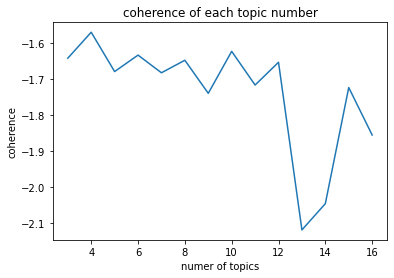

In [16]:
plt.plot(n_topics, coherence_list)
plt.ylabel('coherence')
plt.xlabel('numer of topics')
plt.title('coherence of each topic number')
plt.show

local maximum으로 6,8개가 적당해보임

In [17]:
coherence_result_iter100_batch10 = pd.DataFrame(zip(n_topics,coherence_list), columns=['n_topics','coherence'])
coherence_result_iter100_batch10

,n_topics,coherence
0,3,-1.642344
1,4,-1.570147
2,5,-1.679512
3,6,-1.633750
4,7,-1.682889
5,8,-1.648031
6,9,-1.740035
7,10,-1.623255
8,11,-1.717006
9,12,-1.653637


### n_Topics 6

In [18]:
n_topics

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [19]:
W_res

[array([[3.85308742e+01, 1.97241177e+01, 3.97949369e+02],
        [2.59155714e+02, 1.38826542e+01, 1.51766001e+02],
        [1.31363231e+02, 1.93183567e+02, 8.05300615e+01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 1.65023447e-01],
        [0.00000000e+00, 0.00000000e+00, 1.65023447e-01],
        [0.00000000e+00, 0.00000000e+00, 1.65023447e-01]]),
 array([[4.15986547e-013, 4.82737998e+001, 5.08925873e+002,
         2.25108412e+001],
        [2.76768129e+001, 1.03574922e+002, 3.60006629e+002,
         7.93415396e+001],
        [2.33450011e+002, 8.86068370e+001, 1.53897172e+002,
         5.61523426e+001],
        ...,
        [0.00000000e+000, 2.49959676e-001, 3.67533603e-162,
         0.00000000e+000],
        [0.00000000e+000, 2.49959676e-001, 0.00000000e+000,
         0.00000000e+000],
        [0.00000000e+000, 2.49959676e-001, 0.00000000e+000,
         0.00000000e+000]]),
 array([[9.38372278e+01, 4.62359683e+02, 1.45671139e+02, 9.58058930e-10,
         2.55496588e+01],
 

In [61]:
top10_per_topic(W_res[3]).iloc[:,list(range(0,8*2,2))]

,topics_1,weight_1,topics_2,weight_2,topics_3,weight_3,topics_4,weight_4,topics_5,weight_5,topics_6,weight_6
0,달러,385.474846,시장,387.772350,경제,547.013821,에너지,216.678167,코로나,605.961072,미국,346.219028
1,예상,364.252850,개발,359.501963,서울,469.159282,사용,197.400710,한국,500.193483,분기,294.094917
2,규모,364.021105,확대,299.012038,수준,326.436383,대표,172.769240,투자,466.461878,중국,293.843525
3,기준,354.085153,백신,292.423934,개발,322.694519,규제,127.217739,영업,409.609317,증가,263.490623
4,상황,334.464810,서비스,237.476935,최고,272.761735,협력,126.823451,기업,354.187601,사회,225.941200
5,발생,307.932481,투자,235.050905,펀드,247.781081,개인,125.888684,기술,335.403791,금융,219.818002
6,국가,285.526038,산업,233.366585,콘텐츠,183.822188,전략,122.455085,실적,319.831414,변화,213.150498
7,제목,261.174862,주가,229.378219,지수,177.331358,검사,121.638458,내년,316.830017,포함,209.461010
8,기록,255.833555,분기,194.525836,추진,153.598040,아파트,121.066635,가격,305.125342,후보,196.336880
9,결과,240.778475,국내,189.313539,다양,152.584535,현지,117.733132,매출,282.120671,현대,192.173770


토픽이 엄청 다양한 느낌이 없음... 특히 2,3,4가 너무 비슷

### n_Topics 8

In [21]:
n_topics

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [27]:
top10_per_topic(W_res[5]).iloc[:,list(range(0,8*2,2))]

,words_1,weight_1,words_2,weight_2,words_3,weight_3,words_4,weight_4,words_5,weight_5,words_6,weight_6,words_7,weight_7,words_8,weight_8
0,분기,738.659256,코로나,618.262747,후보,678.272407,지원,398.773768,금융,587.486352,보상,365.418558,기업,378.623655,고객,436.308776
1,기록,640.306284,접종,306.004364,국민,572.834456,주택,269.563102,투자,436.620754,고객,226.062690,대표,345.766099,서비스,357.163115
2,상승,583.843807,백신,282.446072,대통령,403.593886,서울,262.134224,시장,407.057595,장애,217.009123,기술,283.832824,개발,348.576761
3,증가,582.228491,확진,271.263589,대표,387.036871,사회,257.777604,거래,332.760165,서비스,207.353150,그룹,283.415601,할인,309.442404
4,실적,541.595192,방역,223.331167,대선,339.194600,기업,256.786415,대출,311.953954,센터,186.035995,경영,263.816147,혜택,261.935252
5,위안,511.335526,위드,208.021508,의원,249.434512,도시,248.696505,은행,240.458825,인터넷,185.526403,성장,241.285470,제품,250.005143
6,매출,409.455363,단계,199.377047,회의,221.761171,지역,242.664347,자산,214.397333,롯데,173.005870,수소,239.904589,카드,244.664594
7,매수,403.974436,회복,189.589563,미국,193.336006,서울시,199.407720,미국,196.799018,요금,166.371304,소재,234.707428,사용,217.811719
8,기준,403.806220,일상,187.932703,정치,189.747473,가구,191.315397,금리,189.369386,기준,161.407217,글로벌,234.168290,출시,215.484803
9,투자,396.889002,검사,165.819044,국가,186.150786,개발,186.432021,서비스,187.956917,적용,148.448540,회사,221.065758,이벤트,213.029089


`8개의 토픽이 다양하고 적절해보임`

# iteration 수 : `50으로 결정`

batch1 에 대해서 topic 수 8개로  error 확인해본 결과 50이상부터는 그래프가 꺾이는 포인트가 보임

In [29]:
# Randomly initialize W, H with nonnegative values : uniform (1,2)
rank=8
W = np.random.uniform(1,2,(X.shape[0], rank))
H = np.random.uniform(1,2,(rank,X.shape[1]))
H, W, errors = NMF(100, 8, X, W, H)

100%|█████████████████████████████████████████| 100/100 [03:39<00:00,  2.20s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

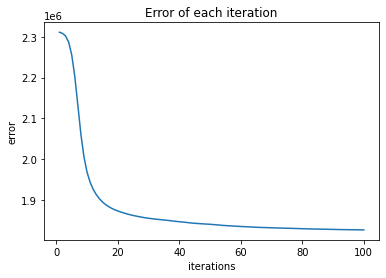

In [30]:
plt.plot(list(range(1,iters+1)), errors)
plt.ylabel('error')
plt.xlabel('iterations')
plt.title('Error of each iteration')
plt.show

# Result

In [54]:
#hyperparameters
batch = 10
rank = 8
iters = 50

In [55]:
W_batch = []
H_batch = []
errors_batch = []
coherence_list_batch = []

In [59]:
import time

In [60]:
start = time.time()
for b in range(batch):
    vocab = open_vocab('vocab_mecab{}.txt'.format(b+1))
    data = open_vocab_freq_per_doc('vocab_freq_per_doc_mecab{}.txt'.format(b+1))
    X = construct_X(vocab, data)
    
    # Randomly initialize W, H with nonnegative values : uniform (1,2)
    W = np.random.uniform(1,2,(X.shape[0], rank))
    H = np.random.uniform(1,2,(rank,X.shape[1]))
    H_new, W_new, errors_new = NMF(iters, rank, X, W, H)
    H_batch.append(H_new)
    W_batch.append(W_new)
    errors_batch.append(errors_new)
    topics = top10_per_topic(W_new).iloc[:,list(range(0,rank*2,2))].T.values.tolist()
    coherence_list_batch.append(coherence(topics, corpus, dictionary))
time.time()-start

100%|███████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


1535.4053649902344

# 결과

In [64]:
top10_per_topic(W_batch[0]).iloc[:,list(range(0,rank*2,2))]

,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8
0,상승,영업,경제,분기,시장,달러,미국,투자
1,국내,금융,서울,상황,확대,기준,사회,코로나
2,포함,한국,개발,요소,개발,예상,출시,내년
3,개인,변화,최고,오후,산업,규모,현대,매출
4,회의,코로나,펀드,결과,백신,확진,공개,한국
5,공급,기술,지수,시장,수요,기업,추가,하락
6,중국,연속,다양,정부,전략,정책,계약,기술
7,기업,보고서,대출,발생,공동,은행,중국,기업
8,지역,증가,수준,가격,문제,방송,생각,가격
9,탄소,분기,후보,증가,중국,국가,수준,실적


In [65]:
top10_per_topic(W_batch[1]).iloc[:,list(range(0,rank*2,2))]

,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8
0,매출,이익,기록,미국,중국,규모,기준,분기
1,서비스,시장,수준,문제,현지,개발,가능,서울
2,성장,대표,발표,최대,환경,국민,대상,시장
3,투자,개발,결정,전환,서울,변화,판매,기업
4,공급,금융,계약,센터,운영,공개,기업,설명
5,세계,지역,한국,출시,건강,해당,회사,코로나
6,산업,달러,조사,발생,모습,상품,필요,사회
7,업계,연속,가격,주택,원전,기술,글로벌,국가
8,정부,신규,투자,협력,접종,증가,비교,도시
9,상승,의원,체결,장기,증가,임상,석탄,치료제


In [67]:
top10_per_topic(W_batch[2]).iloc[:,list(range(0,rank*2,2))]

,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8
0,달러,투자,미국,규모,정상,코로나,개발,제품
1,매매,증가,영업,이익,적용,백신,한국,주택
2,효과,기록,분기,신규,서울,업체,시장,기존
3,뉴스,가능,참여,최고,비율,주요,중국,수준
4,경제,관계자,판매,가능,콘텐츠,유럽,가격,상승
5,사용,기업,수익,연구원,바이오,건강,대표,기업
6,현지,달러,서비스,모습,환경,서울,정부,지수
7,사장,해외,산업,비용,펀드,결과,하락,개인
8,예상,국내,게임,매출,소득,우려,경우,과정
9,결과,현대,자산,신청,국제,기준,기업,투자


In [68]:
top10_per_topic(W_batch[3]).iloc[:,list(range(0,rank*2,2))]

,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8
0,시장,영국,개발,기록,전망,기준,대표,달러
1,규모,급등,가능,내년,기업,서울,국내,경제
2,투자,입장,미국,상황,현대,기간,설명,업체
3,결과,전국,발표,사회,시장,코로나,상승,관계자
4,세계,증가,매수,계획,최고,결정,기술,국민
5,경우,플러스,정부,서비스,분기,대통령,지속,주가
6,산업,제도,평가,발전,가격,한국,오후,정상
7,상품,최대,기업,달러,제품,기대,개인,수요
8,공개,글로벌,금융,분기,이익,카카오,시스템,우려
9,대표,매출,기관,메타,하락,임상,매출,금리


In [69]:
top10_per_topic(W_batch[4]).iloc[:,list(range(0,rank*2,2))]

,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8
0,증가,시장,경우,기록,가능,발생,달러,지역
1,개발,정부,상승,영업,시장,의견,후보,상승
2,서울,미국,제목,투자,확대,중국,기술,강화
3,주식,필요,확진,기준,분기,생활,코로나,주가
4,지원,국내,확인,지수,주요,비용,판매,회사
5,시작,경제,서울,도시,경제,보유,참여,국내
6,상황,기업,바이오,활용,기업,투자자,최대,기준
7,가격,투자,규제,미국,요소,경우,분기,접종
8,분석,중국,단계,기대,자동차,기간,대선,플러스
9,계획,서비스,발표,생산,실적,개최,국민,코로나


In [70]:
top10_per_topic(W_batch[5]).iloc[:,list(range(0,rank*2,2))]

,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8
0,상승,개발,기록,코로나,시장,증가,달러,운영
1,가능,지역,모델,투자,산업,게임,주요,업체
2,설명,거래,달러,기업,계획,금융,유지,대표
3,확진,미국,상품,기준,예상,센터,조사,현대
4,기대,차량,제조,가격,발생,경제,개인,반도체
5,수요,국가,부문,이익,한국,기업,평가,하락
6,분기,확보,의료,서비스,영업,개선,개발,출시
7,현지,후보,지원,시장,규모,장기,회의,미국
8,생각,성장,배송,수익,후보,대상,교육,투자
9,환자,경우,보고서,매출,요소,이달,규모,입장


In [71]:
top10_per_topic(W_batch[6]).iloc[:,list(range(0,rank*2,2))]

,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8
0,가능,기업,코로나,한국,경제,추가,달러,기간
1,개발,기록,현지,투자,미국,확인,후보,증가
2,정부,확진,미국,기관,주가,출시,결과,투자
3,지속,미국,발표,분기,상승,코로나,시장,필요
4,시장,서울,뉴스,발생,추진,대선,운영,하락
5,평가,중국,규모,상황,주식,공동,확대,국민
6,관계자,게임,해당,최대,기업,경영,중국,분기
7,기술,사람,동향,일본,지역,강조,자산,디지털
8,서비스,탄소,지역,기록,그룹,아시아,상품,버스
9,증가,연구,교육,해외,글로벌,시행,기준,내년


In [72]:
top10_per_topic(W_batch[7]).iloc[:,list(range(0,rank*2,2))]

,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8
0,가능,투자,시장,분기,하락,한국,급등,개발
1,발표,후보,가격,기록,대상,혐의,세계,해외
2,글로벌,산업,지속,코로나,교육,내용,기업,기준
3,펀드,중국,기업,미국,그룹,전략,백화점,기간
4,아파트,전망,정부,제품,일본,뉴스,운영,사용
5,본부,국민,미국,금리,한국,매도,거래,필요
6,상승,분기,금융,결과,기업,규모,논의,달러
7,동향,주가,서울,최고,소득,공급,청년,투자
8,은행,반도체,시설,사회,전문,상장,반면,국내
9,수사,접종,상황,자산,신규,차량,백신,시장


In [73]:
top10_per_topic(W_batch[8]).iloc[:,list(range(0,rank*2,2))]

,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8
0,시장,기업,출시,경제,온라인,기술,개발,코로나
1,경우,이익,미국,분기,기록,상승,달러,투자
2,기준,지속,지역,정부,석탄,산업,서울,중국
3,현지,생산,문화,상황,이용,대표,가격,지원
4,유지,시설,분야,투자,프로그램,세계,미국,실적
5,신규,참여,기준,거래,경찰,시작,후보,수준
6,대표,부문,과정,한국,대책,매수,국내,펀드
7,증가,건설,민간,공급,참석,영업,업체,개발
8,시스템,전략,기관,요소,모바일,해당,코로나,회사
9,일본,운영,포함,분석,시장,해외,시장,입장


In [74]:
top10_per_topic(W_batch[9]).iloc[:,list(range(0,rank*2,2))]

,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8
0,기업,투자,달러,개발,서비스,코로나,후보,기준
1,지원,기록,시장,확진,기업,백신,대통령,외국인
2,산업,상승,가격,주택,콘텐츠,접종,국민,배터리
3,한국,주가,금리,분양,증가,요소,대선,분기
4,지속,중국,미국,도시,고객,막걸리,조사,주식
5,기술,매수,지수,아파트,분기,임상,의원,매매
6,가능,미국,상승,지역,한국,달러,정부,기업
7,사회,분기,하락,치료,매출,중국,민주당,업체
8,서울,이익,예상,가구,소득,국내,대표,개인
9,경제,영업,인상,코로나,투자,위안,정상,모바일
